##      **Pharmaceutical Drugs and Vitamins Images Detection**

# Downloading the Dataset
First, we need to install the Kaggle API and authenticate it to download the "Pharmaceutical Drugs and Vitamins Images " dataset.

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d vencerlanz09/pharmaceutical-drugs-and-vitamins-dataset-v2
!unzip pharmaceutical-drugs-and-vitamins-dataset-v2.zip -d pharmaceutical-drugs-and-vitamins-dataset

Streaming output truncated to the last 5000 lines.
  inflating: pharmaceutical-drugs-and-vitamins-dataset/Capsure Dataset/Val/Lactezin/20230628_104908_030.jpg  
  inflating: pharmaceutical-drugs-and-vitamins-dataset/Capsure Dataset/Val/Lactezin/20230628_104932_001.jpg  
  inflating: pharmaceutical-drugs-and-vitamins-dataset/Capsure Dataset/Val/Lactezin/20230628_104932_002.jpg  
  inflating: pharmaceutical-drugs-and-vitamins-dataset/Capsure Dataset/Val/Lactezin/20230628_104932_003.jpg  
  inflating: pharmaceutical-drugs-and-vitamins-dataset/Capsure Dataset/Val/Lactezin/20230628_104932_004.jpg  
  inflating: pharmaceutical-drugs-and-vitamins-dataset/Capsure Dataset/Val/Lactezin/20230628_104932_005.jpg  
  inflating: pharmaceutical-drugs-and-vitamins-dataset/Capsure Dataset/Val/Lactezin/20230628_104932_006.jpg  
  inflating: pharmaceutical-drugs-and-vitamins-dataset/Capsure Dataset/Val/Lactezin/20230628_104932_007.jpg  
  inflating: pharmaceutical-drugs-and-vitamins-dataset/Capsure Datase

# Creating CSV files for train and test dataset :-

we are pre-processing the data and creating train_data.csv  and test_data.csv file with columns image_path and label for further processing:-


In [ ]:
import os
import pandas as pd
import random

# Directories for train and validation datasets
train_dir = '/content/pharmaceutical-drugs-and-vitamins-dataset/Capsure Dataset/Train Image'
valid_dir = '/content/pharmaceutical-drugs-and-vitamins-dataset/Capsure Dataset/Val'

# Initialize lists to hold image paths and labels
image_paths = []
labels = []

# Number of images per class
num_classes = 20
total_images = 10000
images_per_class = total_images // num_classes

# Function to process each directory (train or valid)
def process_directory(directory, label_list, path_list):
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):
            images = [os.path.join(label_dir, img) for img in os.listdir(label_dir) if img.endswith('.jpg') or img.endswith('.png')]
            random.shuffle(images)  # Shuffle the images to ensure randomness
            selected_images = images[:images_per_class]  # Select a subset of images
            path_list.extend(selected_images)
            label_list.extend([label] * len(selected_images))

# Process the train and valid directories
process_directory(train_dir, labels, image_paths)

# Create DataFrame and save to CSV
data = {'Image_Path': image_paths, 'Label': labels}
df = pd.DataFrame(data)

csv_file_path = '/content/pharmaceutical-drugs-and-vitamins-dataset/Capsure Dataset/train_data.csv'
df.to_csv(csv_file_path, index=False)

print("CSV file for train and valid folders saved successfully!")

CSV file for train and valid folders saved successfully!


In [ ]:
import os
import pandas as pd

# Directory for the test dataset
test_dir = '/content/pharmaceutical-drugs-and-vitamins-dataset/Capsure Dataset/Test'

# Initialize lists to hold image paths and labels
test_image_paths = []
test_true_labels = []
predicted_labels = []

# Function to process the test directory
def process_test_directory(directory, path_list, true_label_list, predicted_label_list):
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):
            images = [os.path.join(label_dir, img) for img in os.listdir(label_dir) if img.endswith('.jpg') or img.endswith('.png')]
            path_list.extend(images)
            true_label_list.extend([label] * len(images))
            predicted_label_list.extend(['unknown'] * len(images))

# Process the test directory
process_test_directory(test_dir, test_image_paths, test_true_labels, predicted_labels)

# Create DataFrame for test data and save to CSV
test_data = {'Image_Path': test_image_paths, 'True_Label': test_true_labels, 'Predicted_Label': predicted_labels}
test_df = pd.DataFrame(test_data)

test_csv_file_path = '/content/pharmaceutical-drugs-and-vitamins-dataset/Capsure Dataset/test_data.csv'
test_df.to_csv(test_csv_file_path, index=False)

print("CSV file for test folder saved successfully!")

CSV file for test folder saved successfully!


# Importing Libraries :-

we need to import machine learning related API's for image processing , manipulating layers and model Xception , InceptionV3 and ResNet50V2 with pre-trained weights , pandas for reading csv files into dataframes and Matplotlib for creating visualizations, such as line plots, bar charts :-

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import Xception  , DenseNet121 , MobileNet , ResNet50V2  , InceptionV3
from keras import layers, models, optimizers

# Creating Data Generators for Image Classification
This code snippet summarizes the process of creating data generators for training and validation sets . It includes setting up image data augmentation for the training set (train_datagen) and scaling for the testing set (test_datagen), defining the batch size and target image size, and loading the dataset using the flow_from_directory method with categorical class mode for image classification tasks.

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/pharmaceutical-drugs-and-vitamins-dataset/Capsure Dataset/train_data.csv')

# Identify the label column name in your dataset
label_column = 'Label'

# Split the data ensuring equal representation of labels in train and valid sets
train_df, val_df = train_test_split(df, train_size=0.9, test_size=0.1, random_state=42, stratify=df[label_column])

# Check the number of unique labels in both sets
train_unique_labels = train_df[label_column].nunique()
val_unique_labels = val_df[label_column].nunique()
num_classes = len(df['Label'].unique())
print(f"Number of unique labels in training set: {train_unique_labels}")
print(f"Number of unique labels in validation set: {val_unique_labels}")

Number of unique labels in training set: 20
Number of unique labels in validation set: 20


In [ ]:
train_df['Label'] = train_df['Label'].astype(str)
val_df['Label'] = val_df['Label'].astype(str)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32
target_size = (224, 224)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                    x_col='Image_Path',
                                                    y_col='Label',
                                                    target_size=target_size,
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(dataframe=val_df,
                                                        x_col='Image_Path',
                                                        y_col='Label',
                                                        target_size=target_size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical')

Found 9000 validated image filenames belonging to 20 classes.
Found 1000 validated image filenames belonging to 20 classes.


# Exploratory Data Analysis

In [ ]:
# Understand the dataset
print(train_df.head())
print(train_df.shape)
print(train_df.info())
print(train_df.describe())

                                             Image_Path     Label
5876  /content/pharmaceutical-drugs-and-vitamins-dat...    Tempra
1006  /content/pharmaceutical-drugs-and-vitamins-dat...    Flanax
6327  /content/pharmaceutical-drugs-and-vitamins-dat...   Rogin_E
7376  /content/pharmaceutical-drugs-and-vitamins-dat...   Lagundi
9     /content/pharmaceutical-drugs-and-vitamins-dat...  Decolgen
(9000, 2)
<class 'pandas.core.frame.DataFrame'>
Index: 9000 entries, 5876 to 8372
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Image_Path  9000 non-null   object
 1   Label       9000 non-null   object
dtypes: object(2)
memory usage: 210.9+ KB
None
                                               Image_Path   Label
count                                                9000    9000
unique                                               9000      20
top     /content/pharmaceutical-drugs-and-vitamins-dat...  Tempra
freq               

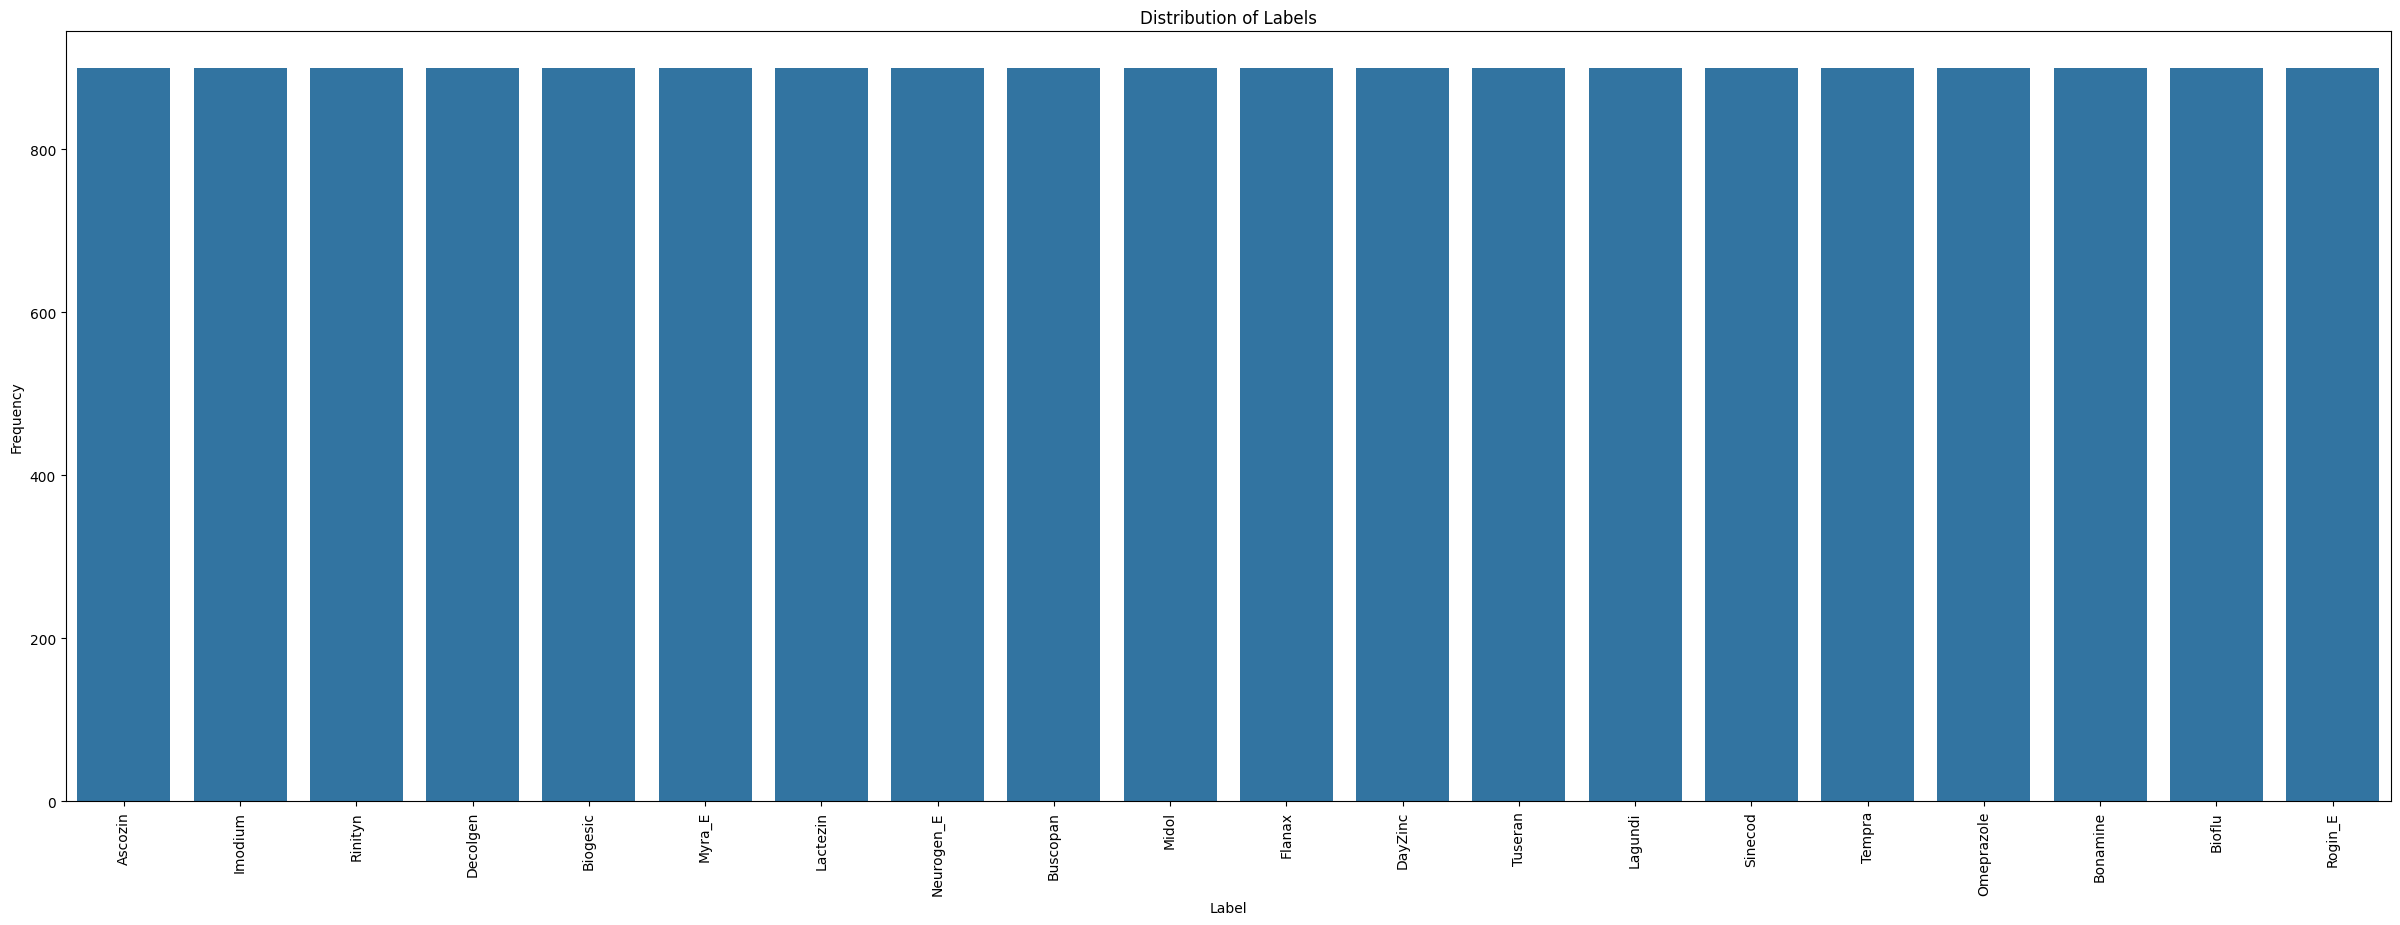

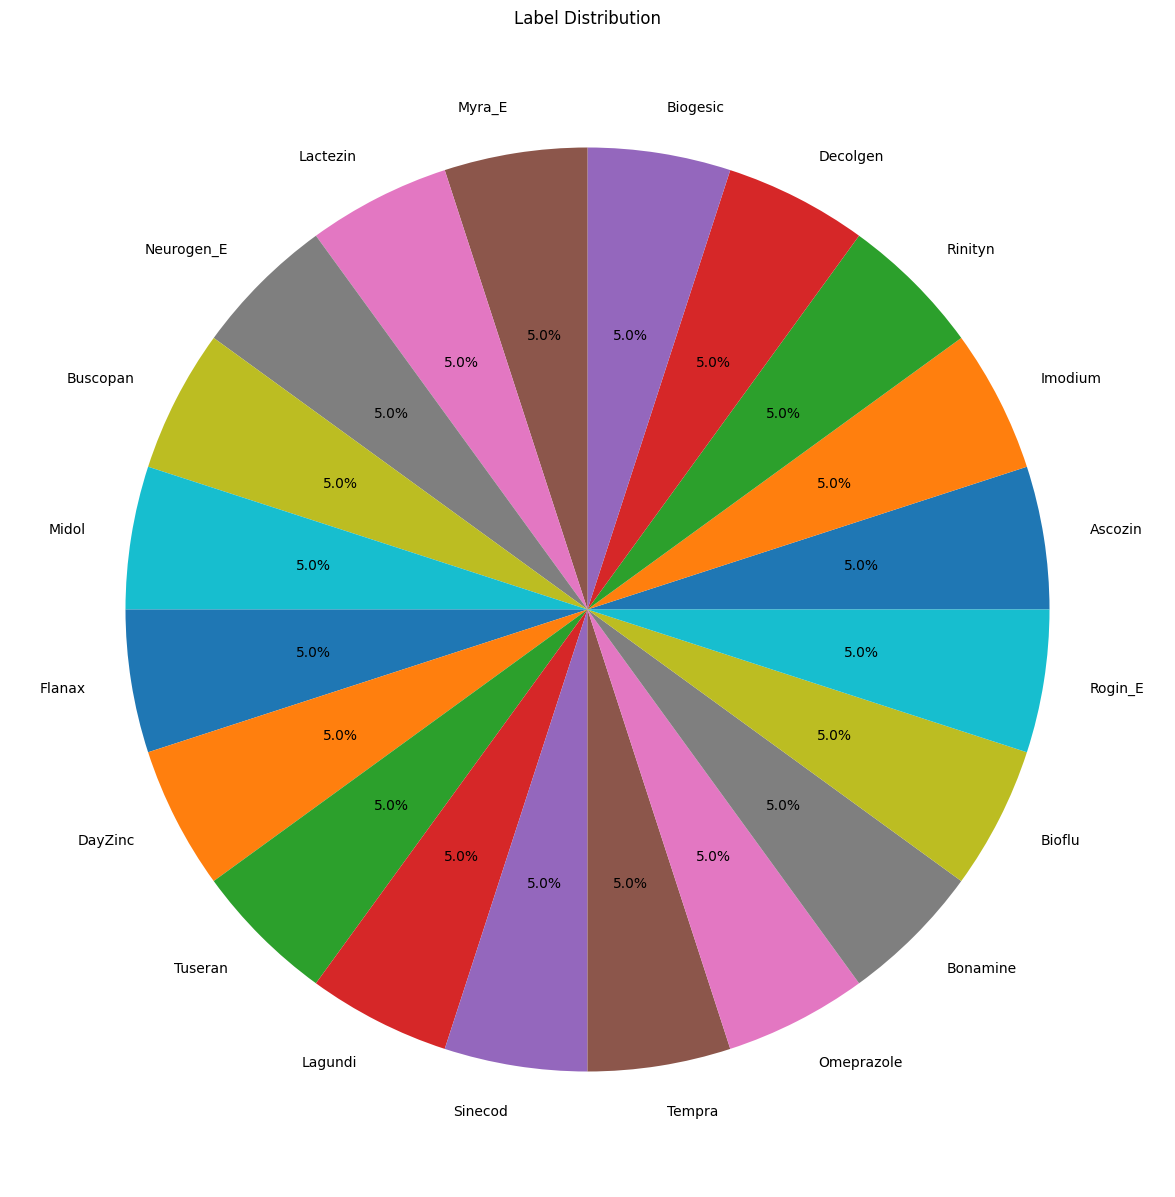

In [ ]:
# Bar chart for label distribution
plt.figure(figsize=(30, 10))
sns.countplot(data=train_df, x='Label', order=train_df['Label'].value_counts().index)
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(rotation=90)  # Rotate x labels for better readability
plt.show()

# Pie chart for label distribution
plt.figure(figsize=(15, 15))
train_df['Label'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Label Distribution')
plt.ylabel('')  # Hide the y-label
plt.show()

Number of unique image paths: 18000


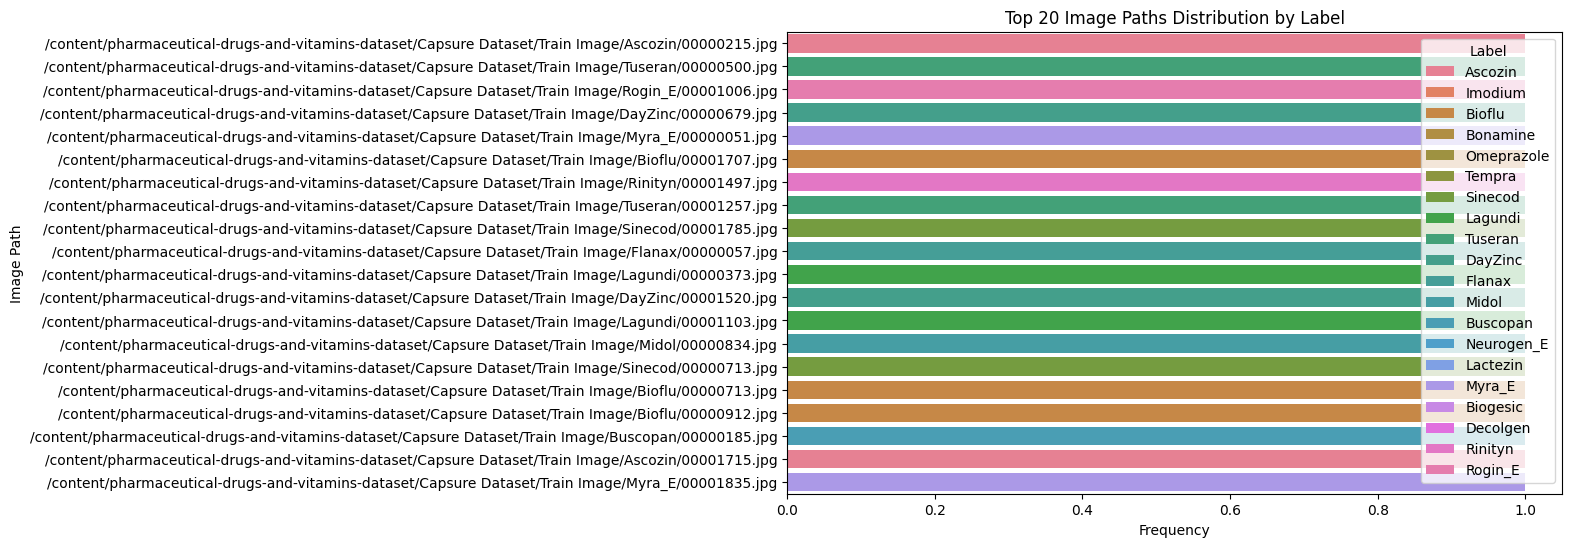

Column Image_Path has 18000 unique values.
Column Label has 20 unique values.


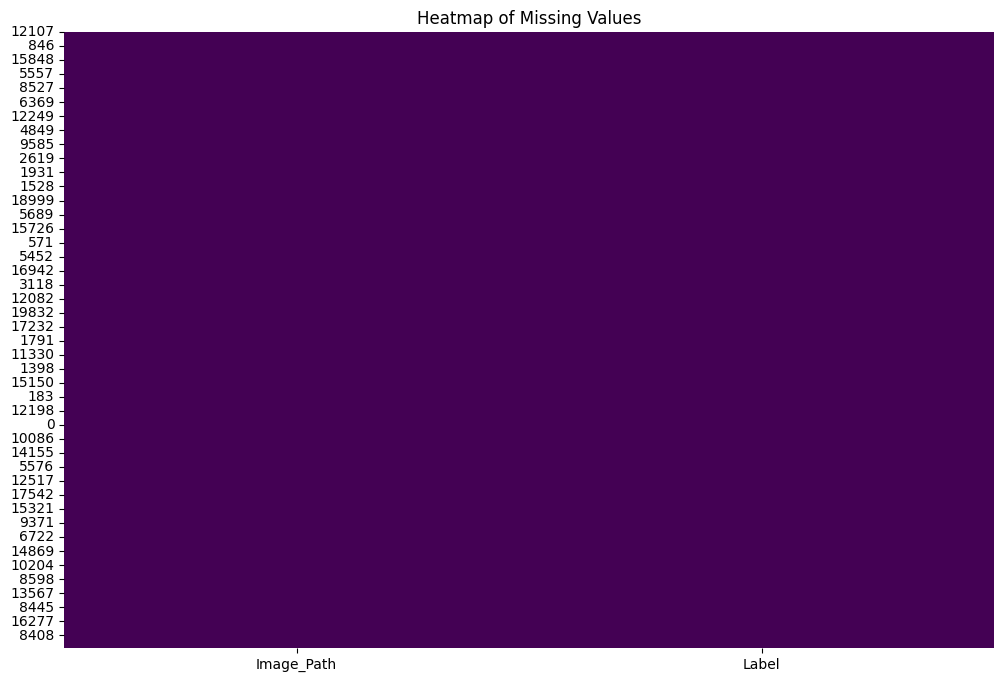

Label
Ascozin       900
Imodium       900
Rinityn       900
Decolgen      900
Biogesic      900
Myra_E        900
Lactezin      900
Neurogen_E    900
Buscopan      900
Midol         900
Flanax        900
DayZinc       900
Tuseran       900
Lagundi       900
Sinecod       900
Tempra        900
Omeprazole    900
Bonamine      900
Bioflu        900
Rogin_E       900
Name: count, dtype: int64


In [ ]:
# Count unique image paths
unique_paths = train_df['Image_Path'].nunique()
print(f"Number of unique image paths: {unique_paths}")

# Image paths distribution by label (top 20 paths for readability)
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, y='Image_Path', hue='Label', order=train_df['Image_Path'].value_counts().index[:20])
plt.title('Top 20 Image Paths Distribution by Label')
plt.xlabel('Frequency')
plt.ylabel('Image Path')
plt.show()

# Unique values for each categorical column
for column in train_df.select_dtypes(include=['object']).columns:
    unique_values = train_df[column].nunique()
    print(f"Column {column} has {unique_values} unique values.")

# Missing values heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(train_df.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Values')
plt.show()

# Label counts summary
label_counts = train_df['Label'].value_counts()
print(label_counts)

In [ ]:
# Data Cleaning
print(train_df.isnull().sum())
train_df.fillna(method='ffill', inplace=True)
print(train_df.duplicated().sum())
train_df.drop_duplicates(inplace=True)

Image_Path    0
Label         0
dtype: int64
0


# Customizing model according to our usecase
This code snippet summarizes the process of creating a custom keras categorical classification model in Keras. It involves loading the pre-trained Xception , VGG16 and ResNet50  model, freezing its layers, adding custom layers for classification, compiling the model, shuffling the training data, and training the model. Finally, the trained model is saved as an HDF5 file .

In [ ]:
from keras import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications import ResNet101V2
from keras.callbacks import EarlyStopping
from keras import optimizers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import os

def create_model(base_model, input_shape, num_classes):
    base_model.trainable = True
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [ ]:
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

def train_and_evaluate(model, train_data, val_data, model_name, epochs=10):
    # Compile the model
    model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model with the specified number of epochs
    history = model.fit(train_data,
                        validation_data=val_data,
                        steps_per_epoch=len(train_data),
                        epochs=epochs,
                        callbacks=[early_stopping])

    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(val_data)
    print(f'{model_name} Validation Accuracy: {val_accuracy:.4f}')

    # Plot training history
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.title(f'{model_name} Accuracy')
    plt.show()

    # Get the true labels and predictions
    val_data.reset()  # Reset the generator
    Y_pred = model.predict(val_data)
    y_pred = np.argmax(Y_pred, axis=1)
    y_true = val_data.classes

    # Generate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Increase the width of the confusion matrix plot
    plt.figure(figsize=(12, 10))  # Set the figure size here (width, height)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_data.class_indices.keys())
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    return history

In [ ]:
def model_training (base_models):
  # Directory to save the models
  save_dir = 'saved_models'
  if not os.path.exists(save_dir):
      os.makedirs(save_dir)

  # Adjustments for ResNet50
  # Train and evaluate each model
  histories = {}
  for base_model, input_shape, model_name in base_models:
      # Resize data if necessary (dummy data, so not applicable here)
      if input_shape != (224, 224, 3):
          # Resize X_train and X_val to the required input_shape
          # This is just a placeholder, implement actual resizing if needed
          pass

      # Create the model
      model = create_model(base_model, input_shape, num_classes)

      if model_name == 'ResNet50':
          # Unfreeze more layers for ResNet50 and adjust learning rate
          for layer in model.layers[-30:]:
              layer.trainable = True
          epochs = 10
          optimizer = optimizers.Adam(learning_rate=0.0001)
      else:
          epochs = 10
          optimizer = optimizers.Adam()

      # Compile the model
      model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

      print(f'Training {model_name}...')
      history = train_and_evaluate(model, train_generator, validation_generator, model_name, epochs=epochs)
      histories[model_name] = history

      # Saving the model after training
      model.save(os.path.join(save_dir, f'{model_name}_saved.h5'))
      print(f'Saved {model_name} model to {save_dir}/{model_name}_saved.h5')

# Loading the Base-Model
This code snippet defines Xception , ResNet50 and VGG16 base model in Keras. The model is configured with an input shape of (224, 224, 3) for VGG16 & ResNet50 and input shape of (299 , 299 , 3) for Xception to match the size and channels of the images in the dataset. It includes all layers of the MobileNetV2 model up to the final fully connected layers but excludes the last fully connected layer, which is often customized for specific tasks.

17225924/17225924 [==============================] - 0s 0us/step
Training MobileNet...
Epoch 1/10
282/282 [==============================] - 170s 528ms/step - loss: 3.0825 - accuracy: 0.0857 - val_loss: 2.6591 - val_accuracy: 0.2920
Epoch 2/10
282/282 [==============================] - 145s 515ms/step - loss: 2.3263 - accuracy: 0.2882 - val_loss: 1.3414 - val_accuracy: 0.6460
Epoch 3/10
282/282 [==============================] - 143s 506ms/step - loss: 1.3691 - accuracy: 0.5754 - val_loss: 0.6084 - val_accuracy: 0.8180
Epoch 4/10
282/282 [==============================] - 145s 515ms/step - loss: 0.8140 - accuracy: 0.7548 - val_loss: 0.3787 - val_accuracy: 0.8850
Epoch 5/10
282/282 [==============================] - 144s 511ms/step - loss: 0.5751 - accuracy: 0.8282 - val_loss: 0.2673 - val_accuracy: 0.9130
Epoch 6/10
282/282 [==============================] - 151s 534ms/step - loss: 0.4418 - accuracy: 0.8681 - val_loss: 0.2314 - val_accuracy: 0.9250
Epoch 7/10
282/282 [=================

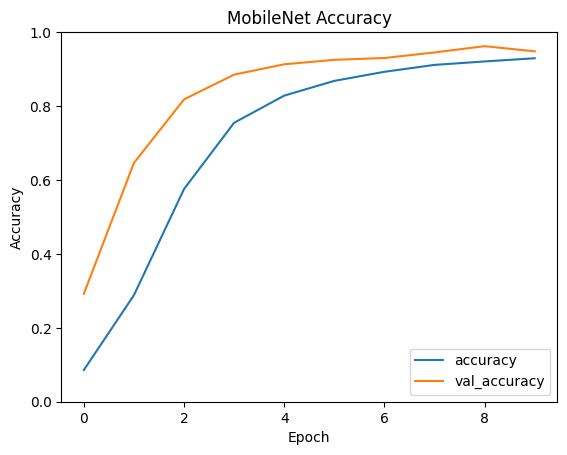

32/32 [==============================] - 3s 90ms/step


<Figure size 1200x1000 with 0 Axes>

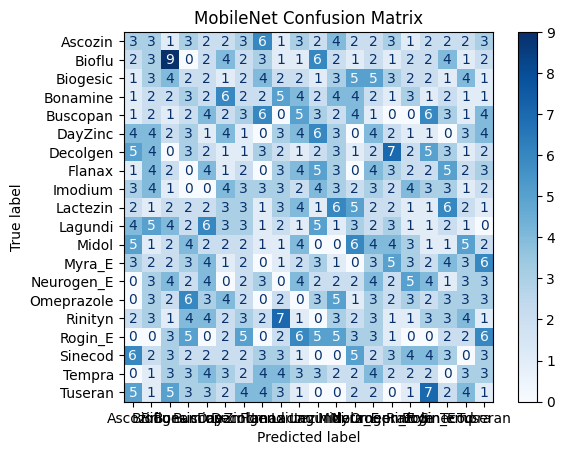

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved MobileNet model to saved_models/MobileNet_saved.h5


In [ ]:
# List of base models with their respective input shapes
base_models1 = [
    (MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3)), (224, 224, 3), 'MobileNet'),
]
model_training(base_models1)

87910968/87910968 [==============================] - 0s 0us/step
Training InceptionV3...
Epoch 1/10
282/282 [==============================] - 213s 588ms/step - loss: 2.8121 - accuracy: 0.1413 - val_loss: 1.7555 - val_accuracy: 0.4980
Epoch 2/10
282/282 [==============================] - 162s 572ms/step - loss: 1.1002 - accuracy: 0.6810 - val_loss: 0.4993 - val_accuracy: 0.8540
Epoch 3/10
282/282 [==============================] - 162s 576ms/step - loss: 0.5090 - accuracy: 0.8574 - val_loss: 0.3421 - val_accuracy: 0.9110
Epoch 4/10
282/282 [==============================] - 158s 560ms/step - loss: 0.3894 - accuracy: 0.8937 - val_loss: 0.3055 - val_accuracy: 0.9290
Epoch 5/10
282/282 [==============================] - 157s 556ms/step - loss: 0.3314 - accuracy: 0.9106 - val_loss: 0.2065 - val_accuracy: 0.9450
Epoch 6/10
282/282 [==============================] - 156s 553ms/step - loss: 0.3079 - accuracy: 0.9167 - val_loss: 0.2271 - val_accuracy: 0.9400
Epoch 7/10
282/282 [===============

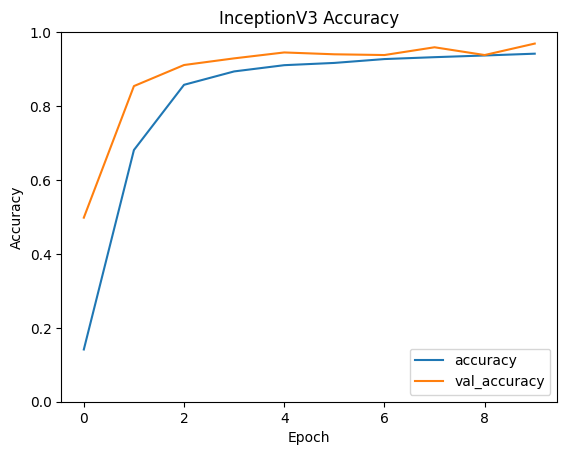

32/32 [==============================] - 4s 94ms/step


<Figure size 1200x1000 with 0 Axes>

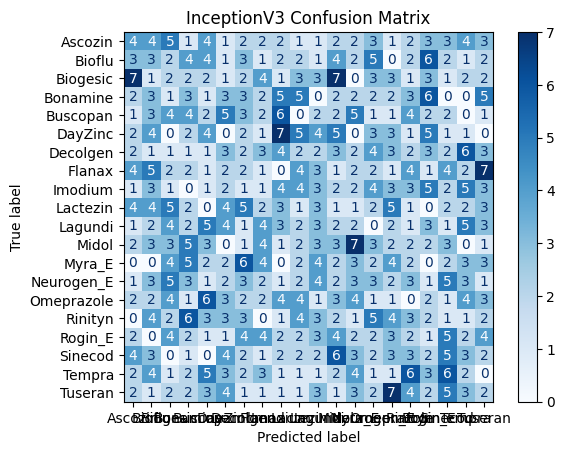

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved InceptionV3 model to saved_models/InceptionV3_saved.h5


In [ ]:
base_models2 = [
  (InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3)), (299, 299, 3), 'InceptionV3')
]
model_training (base_models2)

83683744/83683744 [==============================] - 0s 0us/step
Training Xception...
Epoch 1/10
282/282 [==============================] - 220s 666ms/step - loss: 2.9971 - accuracy: 0.0504 - val_loss: 2.9870 - val_accuracy: 0.1290
Epoch 2/10
282/282 [==============================] - 186s 659ms/step - loss: 1.5177 - accuracy: 0.5494 - val_loss: 0.7038 - val_accuracy: 0.8610
Epoch 3/10
282/282 [==============================] - 184s 651ms/step - loss: 0.4535 - accuracy: 0.8688 - val_loss: 0.1921 - val_accuracy: 0.9420
Epoch 4/10
282/282 [==============================] - 183s 648ms/step - loss: 0.2742 - accuracy: 0.9222 - val_loss: 0.1542 - val_accuracy: 0.9540
Epoch 5/10
282/282 [==============================] - 182s 643ms/step - loss: 0.2189 - accuracy: 0.9391 - val_loss: 0.2158 - val_accuracy: 0.9400
Epoch 6/10
282/282 [==============================] - 182s 645ms/step - loss: 0.1699 - accuracy: 0.9531 - val_loss: 0.1057 - val_accuracy: 0.9650
Epoch 7/10
282/282 [==================

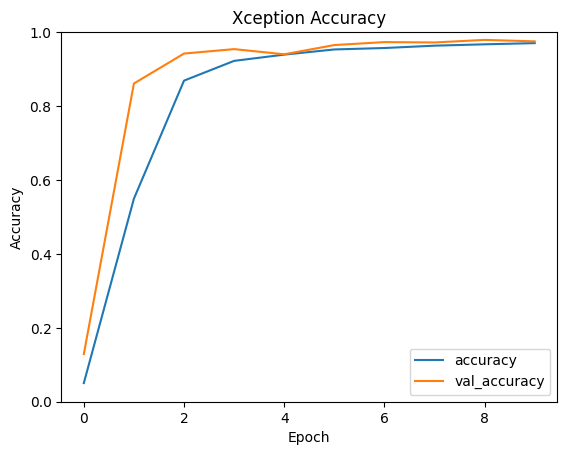

32/32 [==============================] - 6s 151ms/step


<Figure size 1200x1000 with 0 Axes>

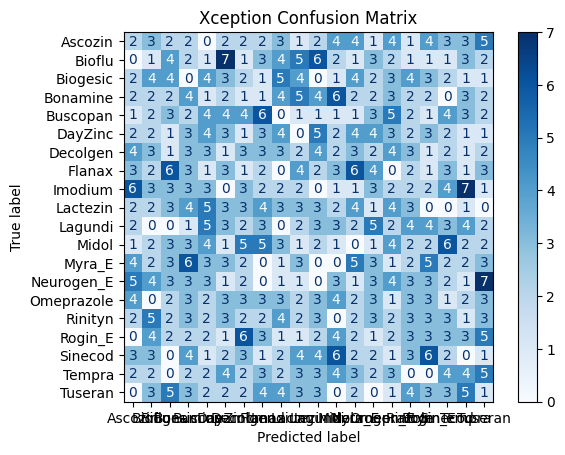

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved Xception model to saved_models/Xception_saved.h5


In [ ]:
base_models3 = [
  (Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3)), (299, 299, 3), 'Xception')
]
model_training (base_models3)

94668760/94668760 [==============================] - 0s 0us/step
Training ResNet50V2...
Epoch 1/10
282/282 [==============================] - 195s 573ms/step - loss: 2.8314 - accuracy: 0.1353 - val_loss: 1.7237 - val_accuracy: 0.4700
Epoch 2/10
282/282 [==============================] - 160s 566ms/step - loss: 1.3304 - accuracy: 0.6103 - val_loss: 0.6920 - val_accuracy: 0.8030
Epoch 3/10
282/282 [==============================] - 161s 569ms/step - loss: 0.6682 - accuracy: 0.8124 - val_loss: 0.4676 - val_accuracy: 0.8710
Epoch 4/10
282/282 [==============================] - 167s 592ms/step - loss: 0.4835 - accuracy: 0.8607 - val_loss: 0.5018 - val_accuracy: 0.8580
Epoch 5/10
282/282 [==============================] - 169s 599ms/step - loss: 0.4136 - accuracy: 0.8840 - val_loss: 0.3534 - val_accuracy: 0.8940
Epoch 6/10
282/282 [==============================] - 166s 587ms/step - loss: 0.3717 - accuracy: 0.8948 - val_loss: 0.2810 - val_accuracy: 0.9230
Epoch 7/10
282/282 [================

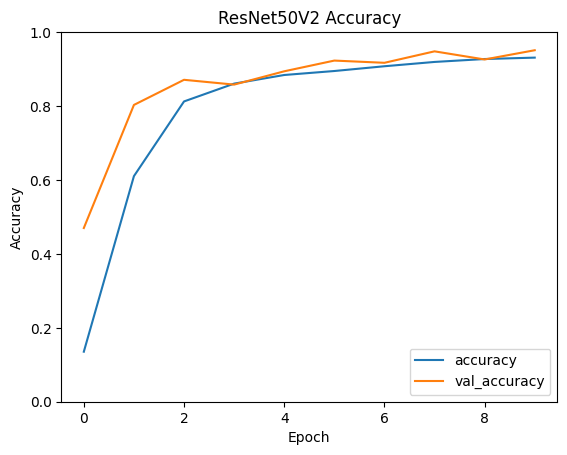

32/32 [==============================] - 4s 98ms/step


<Figure size 1200x1000 with 0 Axes>

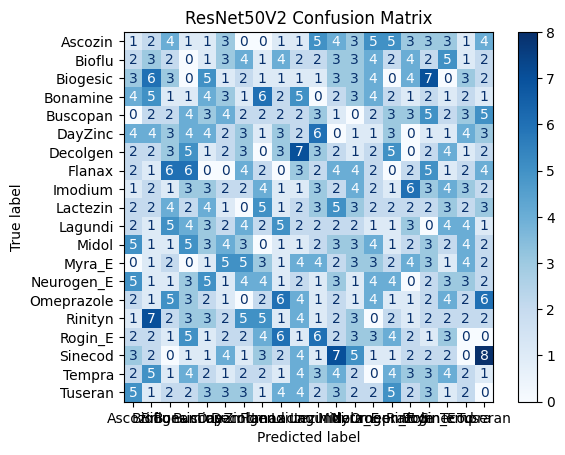

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved ResNet50V2 model to saved_models/ResNet50V2_saved.h5


In [16]:
base_models4 = [
  (ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)), (224, 224, 3), 'ResNet50V2')
]
model_training (base_models4)

29084464/29084464 [==============================] - 0s 0us/step
Training DenseNet121...
Epoch 1/10
282/282 [==============================] - 253s 610ms/step - loss: 2.5631 - accuracy: 0.2371 - val_loss: 0.9561 - val_accuracy: 0.7290
Epoch 2/10
282/282 [==============================] - 168s 596ms/step - loss: 0.8576 - accuracy: 0.7483 - val_loss: 0.2248 - val_accuracy: 0.9460
Epoch 3/10
282/282 [==============================] - 165s 586ms/step - loss: 0.3795 - accuracy: 0.8921 - val_loss: 0.1071 - val_accuracy: 0.9680
Epoch 4/10
282/282 [==============================] - 164s 581ms/step - loss: 0.2588 - accuracy: 0.9258 - val_loss: 0.1437 - val_accuracy: 0.9510
Epoch 5/10
282/282 [==============================] - 168s 593ms/step - loss: 0.2153 - accuracy: 0.9410 - val_loss: 0.1491 - val_accuracy: 0.9570
Epoch 6/10
282/282 [==============================] - 167s 592ms/step - loss: 0.1925 - accuracy: 0.9463 - val_loss: 0.0782 - val_accuracy: 0.9750
Epoch 7/10
282/282 [===============

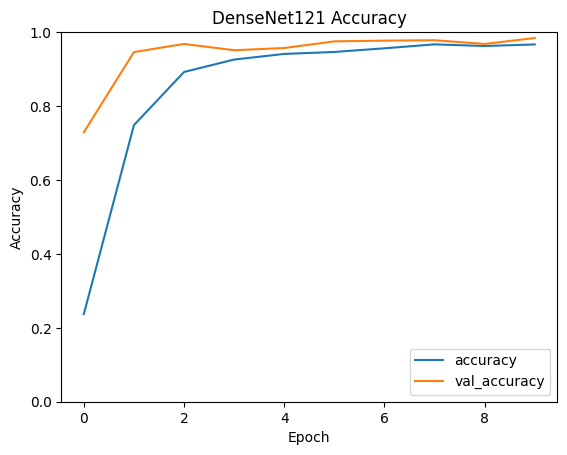

32/32 [==============================] - 6s 106ms/step


<Figure size 1200x1000 with 0 Axes>

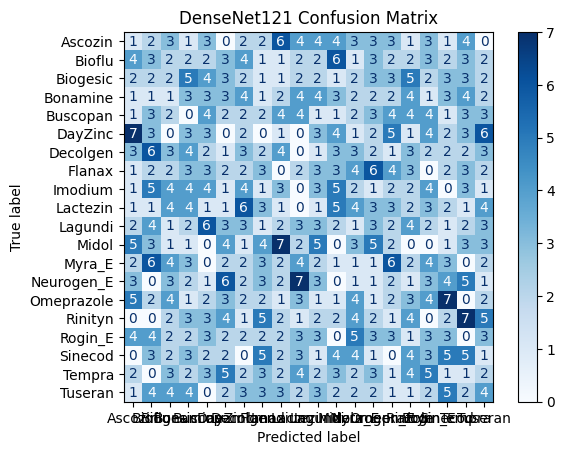

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved DenseNet121 model to saved_models/DenseNet121_saved.h5


In [17]:
# List of base models with their respective input shapes
base_models5 = [
   (DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3)), (224, 224, 3), 'DenseNet121')
]
model_training (base_models5)

# Testing and labeling unseen data

In [18]:
import os
import numpy as np
import pandas as pd
from keras.models import load_model
from keras.preprocessing import image
from tqdm.notebook import tqdm

# Load test dataset
test_df = pd.read_csv('/content/pharmaceutical-drugs-and-vitamins-dataset/Capsure Dataset/test_data.csv')

# Load class indices (assuming you have train_generator with class indices saved)
class_indices_inverse = {v: k for k, v in train_generator.class_indices.items()}

# Directory containing the saved models
model_dir = '/content/saved_models'

# Define batch size
batch_size = 32

# Function to process images in batches
def process_images_in_batches(image_paths, model, target_size, batch_size):
    num_images = len(image_paths)
    num_batches = (num_images + batch_size - 1) // batch_size  # Calculate number of batches

    all_predictions = []

    for batch_idx in tqdm(range(num_batches), desc="Processing batches"):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, num_images)
        batch_paths = image_paths[start_idx:end_idx]

        batch_images = []
        for img_path in batch_paths:
            img = image.load_img(img_path, target_size=target_size)
            img = image.img_to_array(img)
            img = img / 255.0
            batch_images.append(img)

        batch_images = np.array(batch_images)
        batch_predictions_probs = model.predict(batch_images, verbose=0)
        batch_predictions = np.argmax(batch_predictions_probs, axis=1)

        all_predictions.extend(batch_predictions)

    return all_predictions

# Iterate over each model file in the directory
for model_file in os.listdir(model_dir):
    if model_file.endswith('.h5'):
        # Load the model
        model_path = os.path.join(model_dir, model_file)
        model = load_model(model_path)

        # Determine target size based on model
        if "Xception_saved" in model_file or "InceptionV3_saved" in model_file:
            target_size = (299, 299)
        else:
            target_size = (224, 224)

        # Process images in batches and make predictions
        image_paths = test_df['Image_Path'].tolist()
        prediction = process_images_in_batches(image_paths, model, target_size, batch_size)

        # Map predictions to class labels
        prediction_labels = [class_indices_inverse[label] for label in prediction]

        # Create a DataFrame with predictions
        predicted_df = pd.DataFrame({
            'Image_Path': test_df['Image_Path'],
            'True_Label': test_df['True_Label'],
            'Predicted_Label': prediction_labels,
        })

        # Calculate accuracy
        accuracy = np.mean(predicted_df['True_Label'] == predicted_df['Predicted_Label'])

        # Save predictions to CSV
        csv_path = f'/content/saved_models/predicted_{model_file.split(".")[0]}.csv'
        predicted_df.to_csv(csv_path, header=True, index=False)

        print(f"Predictions saved to {csv_path}")
        print(f"Test Accuracy: {accuracy:.2%}")

Processing batches:   0%|          | 0/63 [00:00<?, ?it/s]

Predictions saved to /content/saved_models/predicted_DenseNet121_saved.csv
Test Accuracy: 40.85%


Processing batches:   0%|          | 0/63 [00:00<?, ?it/s]

Predictions saved to /content/saved_models/predicted_MobileNet_saved.csv
Test Accuracy: 38.40%


Processing batches:   0%|          | 0/63 [00:00<?, ?it/s]

Predictions saved to /content/saved_models/predicted_ResNet50V2_saved.csv
Test Accuracy: 35.35%


Processing batches:   0%|          | 0/63 [00:00<?, ?it/s]

Predictions saved to /content/saved_models/predicted_InceptionV3_saved.csv
Test Accuracy: 35.85%


Processing batches:   0%|          | 0/63 [00:00<?, ?it/s]

Predictions saved to /content/saved_models/predicted_Xception_saved.csv
Test Accuracy: 46.50%


# image label and prediction and visualization

Predictions using: predicted_DenseNet121_saved


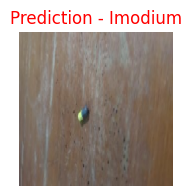

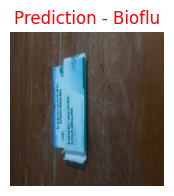

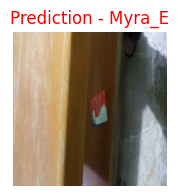

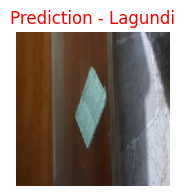

Predictions using: predicted_InceptionV3_saved


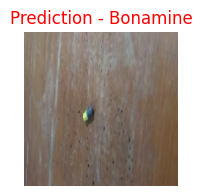

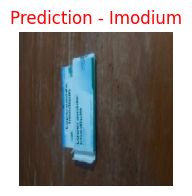

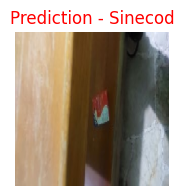

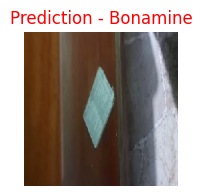

Predictions using: predicted_ResNet50V2_saved


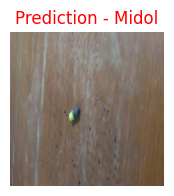

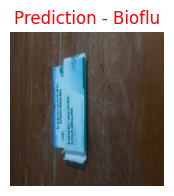

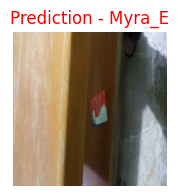

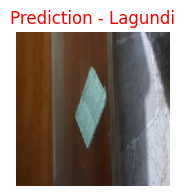

Predictions using: predicted_Xception_saved


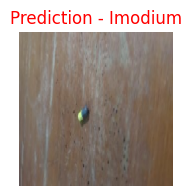

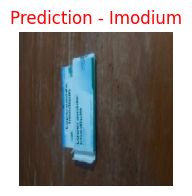

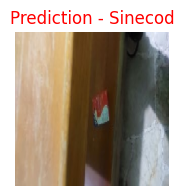

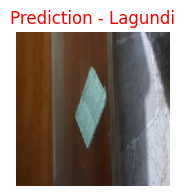

Predictions using: predicted_MobileNet_saved


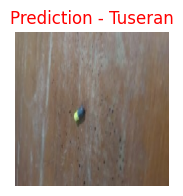

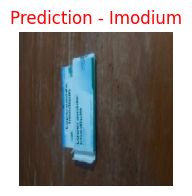

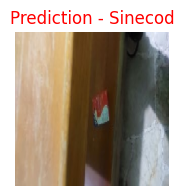

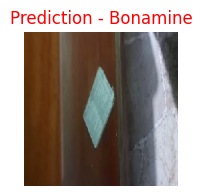

In [20]:
import csv
import os
from keras.preprocessing import image
import matplotlib.pyplot as plt

# Example usage
filenames = [
    '/content/pharmaceutical-drugs-and-vitamins-dataset/Capsure Dataset/Test/Tuseran_Forte/20230628_192627_006.jpg',
    '/content/pharmaceutical-drugs-and-vitamins-dataset/Capsure Dataset/Test/Imodium/20230628_182153_018.jpg',
    '/content/pharmaceutical-drugs-and-vitamins-dataset/Capsure Dataset/Test/Sinecod/20230628_193450_015.jpg',
    '/content/pharmaceutical-drugs-and-vitamins-dataset/Capsure Dataset/Test/Omeprazole/20230628_175939_020.jpg'
]

def load_predicted_labels(csv_file_path):
    predicted_labels = {}
    with open(csv_file_path, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            predicted_labels[row['Image_Path']] = row['Predicted_Label']
    return predicted_labels

def visualize_predictions(filenames, predicted_labels):
    for filename in filenames:
        img = image.load_img(filename, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_processed = img_array / 255.0  # Normalize the image

        # Check if the filename is in predicted_labels
        if filename in predicted_labels:
            predicted_class_name = predicted_labels[filename]
        else:
            print(f"Filename not found: {filename}")
            predicted_class_name = "Unknown"  # Handle cases where filename not found

        plt.figure(figsize=(2, 2))
        plt.imshow(img_processed)  # Display the processed image
        plt.title(f"Prediction - {predicted_class_name}", size=12, color='red')
        plt.axis('off')  # Hide axes
        plt.show()

# Directory containing the predicted CSV files
csv_dir = '/content/saved_models'

# Iterate over each CSV file in the directory
for csv_file in os.listdir(csv_dir):
    if csv_file.startswith('predicted_') and csv_file.endswith('.csv'):
        # Determine the model name
        model_name = csv_file.split('.')[0]

        # Path to the CSV file containing predictions for the current model
        predicted_csv_file = os.path.join(csv_dir, csv_file)

        # Load predicted labels from the CSV file
        predicted_labels = load_predicted_labels(predicted_csv_file)

        # Predict and plot images using predicted labels
        print(f"Predictions using: {model_name}")
        visualize_predictions(filenames, predicted_labels)
